In [1]:
import sys
sys.path.append('/mnt/efs/home/paul/lumos-ncpt-tools') # REMOVE!

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from lumos_ncpt_tools.ncpt import NCPT
from lumos_ncpt_tools.utils import load_data

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Demo functionality of the lumos-ncpt-tools module
### TODO: 
- Check to see if data can be loaded on laptop... 
- Change file paths

### 1) Load up some data! 
- Instantiate a NCPT class object with data from one test battery
- Display some summary info on the entire dataset
- Display info about the subtests in the battery

### 2) Process and plot the scores 
- Filter out outlier raw scores
- Plot the raw score distributions before and after outlier removal
- Lookup normalized scores and the Grand Index (a composite score)
- Plot the normalized scores vs. age

### 3) Miscellaneous 
- Show the meaning of the numeric education levels 
- Filter out users who did not complete the test battery
- Save the filtered/augmented dataset (now has normed scores)

# 1) Load up some data

In [3]:
# Load all of the data from one test battery
battery_id = 39
#data_directory = 'CHANGE/TO/DATA/DIRECTORY' 
#norm_directory = 'CHANGE/TO/NORM/DIRECTORY' 
#save_path = 'CHANGE/TO/SAVE/PATH' # For filtered/processed dataset
data_directory = '/mnt/efs/home/paul/ncpt_data_descriptor/split_by_battery' # CHANGE
norm_directory = '/mnt/efs/home/paul/ncpt_data_descriptor' # CHANGE
save_path = '/mnt/efs/home/paul/ncpt_data_descriptor/demo_df.csv' # CHANGE
data_fn = f'battery{battery_id}_df.csv'
df = load_data(data_directory, data_fn)

# Instantiate a NCPT object, display some basic info
ncpt = NCPT(df)
del df
ncpt.report_stats()
ncpt.get_subtest_info()

Data summary
------------
N users: 236585
N tests: 236585
N subtests: 1770413
DataFrame columns: ['user_id', 'age', 'gender', 'education_level', 'country', 'user_type', 'test_run_id', 'battery_id', 'specific_subtest_id', 'raw_score', 'general_subtest_id']

Subtest information
-------------------
Subtest ID 28: forward_span, v2, N scores = 226451
Subtest ID 29: arithmetic, v2, N scores = 236585
Subtest ID 30: grammatical_reasoning, v2, N scores = 213682
Subtest ID 31: progressive_matrices, v1, N scores = 212448
Subtest ID 33: reverse_span, v2, N scores = 218320
Subtest ID 38: digit_symbol_coding, v1, N scores = 232563
Subtest ID 39: trail_making_A, v1, N scores = 215734
Subtest ID 40: trail_making_B, v1, N scores = 214630



# 2) Process and plot the scores

### Check for outliers

Subtest ID 33: N outliers = 30


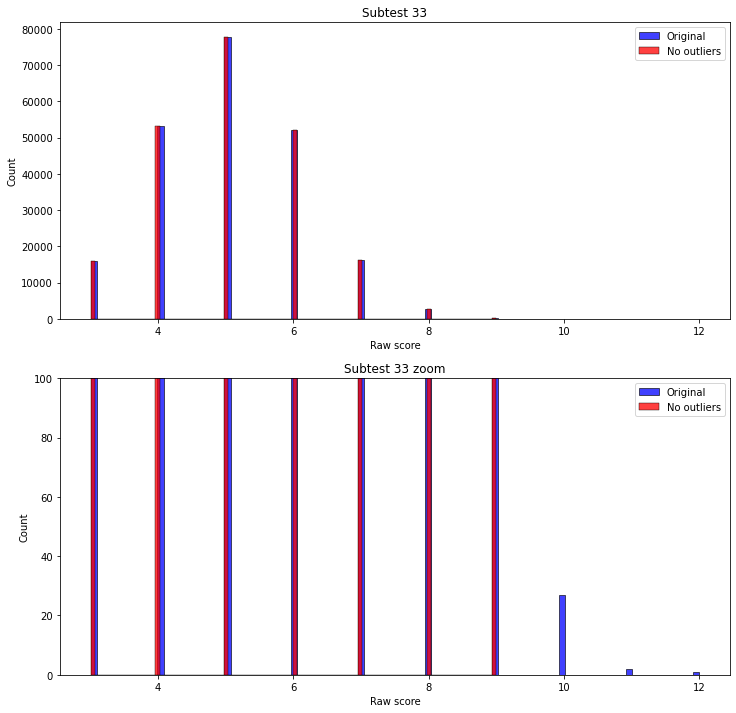

In [4]:
# Remove outlier raw scores using the median absolute deviation (MAD) method
# Note: Depending on the intended application, this may or may not be a sensible thing to do.
outlier_threshold = 5 # fairly conservative threshold
outlier_method = 'MAD'
n_bins = 100
outlier_subtests = [33]
zoom_ylim = [0, 100]
filt_df = ncpt.filter_outliers_by_subtest('raw_score', outlier_threshold, 
                                          outlier_subtests, method=outlier_method)

# Plot the raw score distributions before and after outlier removal
for sub in outlier_subtests:
    orig_sub_df = ncpt.df.query('specific_subtest_id == @sub')
    filt_sub_df = filt_df.query('specific_subtest_id == @sub')
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))
    for ax_ind, ax in enumerate(axes):
        sns.histplot(orig_sub_df['raw_score'], color='b', bins=n_bins, kde=False, ax=ax, label='Original')
        sns.histplot(filt_sub_df['raw_score'], color='r', bins=n_bins, kde=False, ax=ax, label='No outliers')
        ax.set_xlabel('Raw score')
        ax.set_ylabel('Count')
        ax.legend()
        if ax_ind == 1:
            ax.set_ylim(zoom_ylim)
            ax.set_title(f'Subtest {sub} zoom')
        else:
            ax.set_title(f'Subtest {sub}')
    plt.show()


### Look up normalized scores

Looking up norms...
Looking up norms for subtest ID 29
Looking up norms for subtest ID 38
Looking up norms for subtest ID 28
Looking up norms for subtest ID 33
Looking up norms for subtest ID 39
Looking up norms for subtest ID 40
Looking up norms for subtest ID 30
Looking up norms for subtest ID 31
Done! Added normalized scores in column rank_INT_normed_score
Adding grand index...
Done! Added composite score in column grand_index
Subtest 29
Mean of normed scores: 101.4574646430535
Std. dev. of normed scores: 15.484191945087657
-------------------------


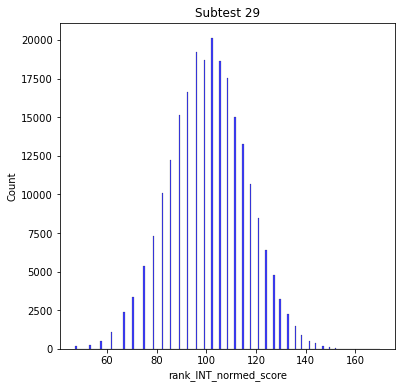

Subtest 38
Mean of normed scores: 100.40924737249006
Std. dev. of normed scores: 15.215323543894419
-------------------------


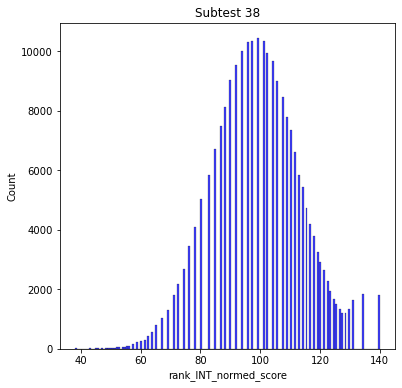

Subtest 28
Mean of normed scores: 100.80928828185183
Std. dev. of normed scores: 14.11352739537339
-------------------------


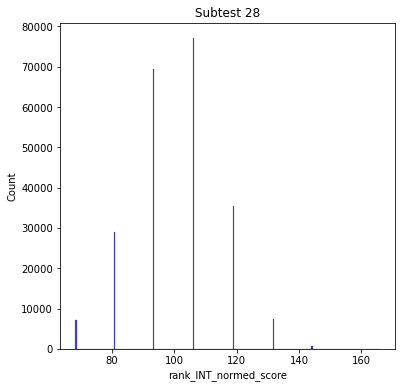

Subtest 33
Mean of normed scores: 100.6720226694628
Std. dev. of normed scores: 14.005352928346852
-------------------------


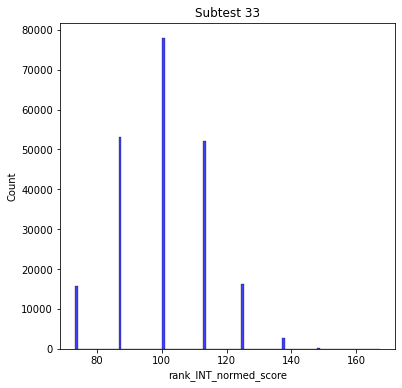

Subtest 39
Mean of normed scores: 100.51704031012751
Std. dev. of normed scores: 14.867544405758656
-------------------------


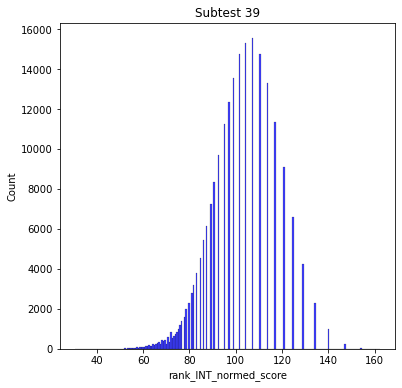

Subtest 40
Mean of normed scores: 100.99300863445372
Std. dev. of normed scores: 14.975940157357702
-------------------------


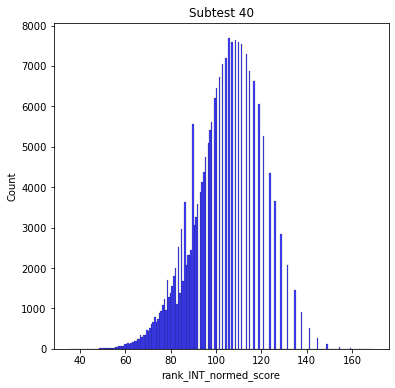

Subtest 30
Mean of normed scores: 100.41544503919805
Std. dev. of normed scores: 14.97923646449547
-------------------------


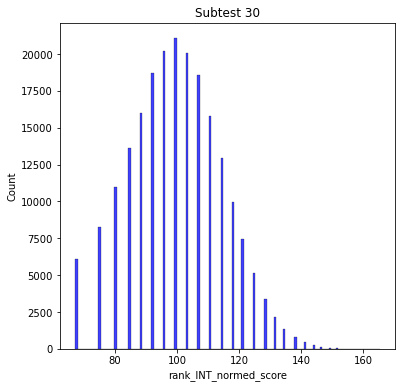

Subtest 31
Mean of normed scores: 100.82962966533653
Std. dev. of normed scores: 14.887968222423627
-------------------------


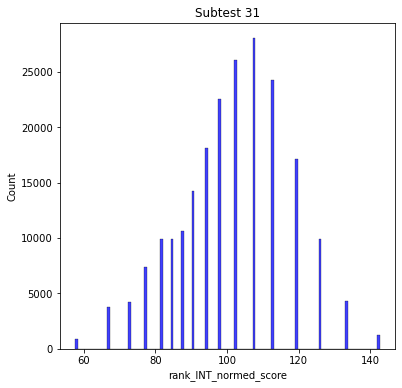

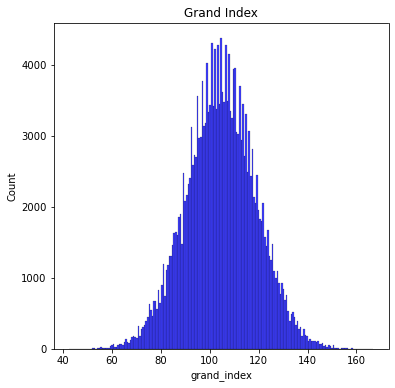

Mean Grand Index: 104.56647558396544
Std. dev. of Grand Index: 14.265436606127968


In [10]:
# Lookup normalized scores using the 'rank_INT' method (see paper for details)
# Also lookup the Grand Index: scores are first normalized using the 'census_rank_INT' method (see paper)
norm_method = 'rank_INT'
score_col = f'{norm_method}_normed_score'
subtests_to_plot = [29, 39, 40]

ncpt.lookup_normed_scores(norm_method, norm_directory)
ncpt.add_grand_index(norm_directory)
print('---------------------------')

# Plot the normalized score distributions
subtests = ncpt.df['specific_subtest_id'].unique()
for sub in subtests_to_plot:
    sub_df = ncpt.df.query('specific_subtest_id == @sub')
    print(f'Subtest {sub}')
    print(f"Mean of normed scores: {sub_df[score_col].mean()}")
    print(f"Std. dev. of normed scores: {sub_df[score_col].std()}")
    fig, axes = plt.subplots(1, 1, figsize=(6, 6))
    sns.histplot(sub_df[score_col], color='b', kde=False, ax=axes)
    axes.set_title(f'Subtest {sub}')
    plt.show()
                 
# Plot the distribution of the Grand Index
GI_df = ncpt.df.drop_duplicates(subset=['test_run_id'])
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
sns.histplot(GI_df['grand_index'], color='b', kde=False, ax=axes)
axes.set_title(f'Grand Index')
plt.show()

# Stats
print(f"Mean Grand Index: {GI_df['grand_index'].mean()}")
print(f"Std. dev. of Grand Index: {GI_df['grand_index'].std()}")

### Plot the Grand Index vs. age
- Red line is best linear fit

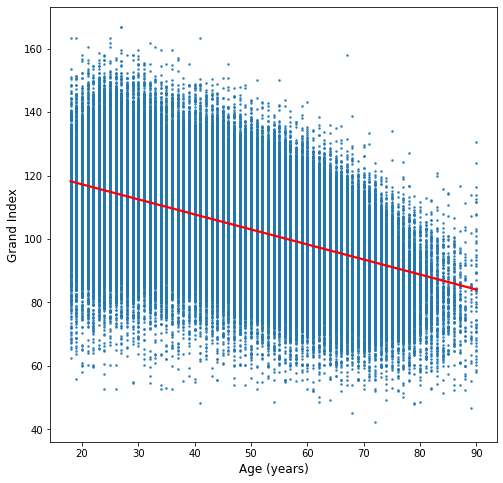

In [6]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
fontsize = 12
sns.regplot(x='age', y='grand_index', data=GI_df, ax=axes, marker='.', 
            scatter_kws={'s': 10}, line_kws={'color': 'r'})
axes.set_xlabel('Age (years)', fontsize=fontsize)
axes.set_ylabel('Grand Index', fontsize=fontsize)
plt.show()

# 3) Miscellaneous

In [7]:
# Display the meaning of the numeric education levels
ncpt.get_education_info()

# Filter out users who did not complete the test battery
filt_df, exclude_df = ncpt.filter_by_completeness()
print(f'Filtered out {len(exclude_df)} subtests')

# Save the filtered/augmented dataset (now has normed scores)
ncpt.save_df(save_path)

Key for education levels
------------------------
1: Some high school
2: High school diploma / GED
3: Some college
4: College degree
5: Professional degree
6: Master's degree
7: Ph.D.
8: Associate's degree
99: Other



NameError: name 'self' is not defined